# Evaluate BLIP-2 Caption Results

## Setup Performance Metrics

In [1]:
pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
pip install evaluate

In [ ]:
import evaluate

### BLEU (Bilingual Evaluation Understudy)
Based on https://huggingface.co/spaces/evaluate-metric/bleu.

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_bleu(predictions, references):
  references = [[ref] for ref in references]
  results = evaluate.load("bleu").compute(predictions=predictions, references=references)
  return str(results)

### METEOR (Metric for Evaluation of Translation with Explicit Ordering)
Based on https://huggingface.co/spaces/evaluate-metric/meteor.

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_meteor(predictions, references):
  results = evaluate.load("meteor").compute(predictions=predictions, references=references)
  return str(results['meteor'])

### ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
Based on https://huggingface.co/spaces/evaluate-metric/rouge.

In [ ]:
pip install rouge_score

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_rouge(predictions, references):
  results = evaluate.load("rouge").compute(predictions=predictions, references=references)
  return str(results)

### WER (Word Error Rate)
Based on https://huggingface.co/spaces/evaluate-metric/wer.

In [ ]:
pip install jiwer

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_wer(predictions, references):
  results = evaluate.load("wer").compute(predictions=predictions, references=references)
  return str(results)

### MAUVE
Based on https://huggingface.co/spaces/evaluate-metric/mauve/.

In [ ]:
pip install mauve-text

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_mauve(predictions, references):
  results = evaluate.load("mauve").compute(predictions=predictions, references=references,device_id=0)
  return str(results.mauve)

### SLA (Semantic Label Accuracy)

In [ ]:
# Input: 1D array of LABELS (length n), 1D array of prediction (length n)
# Output: results (use print)
def evaluate_sla(labels, predictions):
    sum = 0
    for i in range(len(labels)):
        if labels[i] in predictions[i]:
            sum += 1
    return str(sum/len(labels))

### SPICE (Semantic Propositional Image Caption Evaluation)

Based on https://github.com/tylin/coco-caption/tree/master.

In [ ]:
!pip install github-clone
!ghclone https://github.com/tylin/coco-caption/tree/master/pycocoevalcap/spice/lib
!wget -nc https://github.com/tylin/coco-caption/raw/master/pycocoevalcap/spice/spice-1.0.jar

Cloning into 'lib'...
done.
File ‘spice-1.0.jar’ already there; not retrieving.



In [ ]:
# Modified from https://github.com/tylin/coco-caption/blob/master/get_stanford_models.sh

sh = """#!/usr/bin/env sh
# This script downloads the Stanford CoreNLP models.

CORENLP=stanford-corenlp-full-2015-12-09
SPICELIB=lib
JAR=stanford-corenlp-3.6.0

DIR="$( cd "$(dirname "$0")" ; pwd -P )"
cd $DIR

if [ -f $SPICELIB/$JAR.jar ]; then
  echo "Found Stanford CoreNLP."
else
  echo "Downloading..."
  wget http://nlp.stanford.edu/software/$CORENLP.zip
  echo "Unzipping..."
  unzip $CORENLP.zip -d $SPICELIB/
  mv $SPICELIB/$CORENLP/$JAR.jar $SPICELIB/
  mv $SPICELIB/$CORENLP/$JAR-models.jar $SPICELIB/
  rm -f $CORENLP.zip
  rm -rf $SPICELIB/$CORENLP/
  echo "Done."
fi
"""

import os.path
if not os.path.isfile('get_stanford_models.sh'):
  with open('get_stanford_models.sh', 'w') as file:
    file.write(sh)

!bash get_stanford_models.sh

Found Stanford CoreNLP.


In [ ]:
# Modified from https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/spice/spice.py

from __future__ import division
import os
import sys
import subprocess
import threading
import json
import numpy as np
import ast
import tempfile

# Assumes spice.jar is in the same directory as spice.py.  Change as needed.
SPICE_JAR = 'spice-1.0.jar'
TEMP_DIR = 'tmp'
CACHE_DIR = 'cache'

class Spice:
    """
    Main Class to compute the SPICE metric
    """

    def float_convert(self, obj):
        try:
          return float(obj)
        except:
          return np.nan

    def compute_score(self, res, gts):

        # Prepare temp input file for the SPICE scorer
        input_data = []
        for id in range(len(gts)):
            hypo = res[id]
            ref = gts[id]
            input_data.append({
              "image_id" : id,
              "test" : hypo,
              "refs" : [ref]
            })

        cwd = '/content/'
        temp_dir=os.path.join(cwd, TEMP_DIR)
        if not os.path.exists(temp_dir):
          os.makedirs(temp_dir)
        in_file = tempfile.NamedTemporaryFile(delete=False, dir=temp_dir, mode='w')
        json.dump(input_data, in_file, indent=2)
        in_file.close()

        # Start job
        out_file = tempfile.NamedTemporaryFile(delete=False, dir=temp_dir)
        out_file.close()
        cache_dir=os.path.join(cwd, CACHE_DIR)
        if not os.path.exists(cache_dir):
          os.makedirs(cache_dir)
        spice_cmd = ['java', '-jar', '-Xmx8G', SPICE_JAR, in_file.name,
          '-cache', cache_dir,
          '-out', out_file.name,
          '-subset',
          '-silent'
        ]
        subprocess.check_call(spice_cmd, cwd=cwd)

        # Read and process results
        with open(out_file.name) as data_file:
          results = json.load(data_file)
        os.remove(in_file.name)
        os.remove(out_file.name)

        imgId_to_scores = {}
        spice_scores = []
        for item in results:
          imgId_to_scores[item['image_id']] = item['scores']
          spice_scores.append(self.float_convert(item['scores']['All']['f']))
        average_score = np.mean(np.array(spice_scores))
        scores = []
        for image_id in range(len(gts)):
          # Convert none to NaN before saving scores over subcategories
          score_set = {}
          for category,score_tuple in imgId_to_scores[image_id].items():
            score_set[category] = {k: self.float_convert(v) for k, v in score_tuple.items()}
          scores.append(score_set)
        return average_score, scores

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_spice(predictions, references):
  results, _ = Spice().compute_score(predictions, references)
  return str(results)

### CIDer (Consensus-based Image Description Evaluation)
Based on https://github.com/tylin/coco-caption/tree/master.

In [ ]:
# Modeified from https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/cider/cider_scorer.py

#!/usr/bin/env python
# Tsung-Yi Lin <tl483@cornell.edu>
# Ramakrishna Vedantam <vrama91@vt.edu>

import copy
from collections import defaultdict
import numpy as np
import pdb
import math

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        # compute log reference length
        self.ref_len = np.log(float(len(self.crefs)))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            # score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, option=None, verbose=0):
        # compute idf
        self.compute_doc_freq()
        # assert to check document frequency
        assert(len(self.ctest) >= max(self.document_frequency.values()))
        # compute cider score
        score = self.compute_cider()
        # debug
        # print(score)
        return np.mean(np.array(score)), np.array(score)

In [ ]:
# Modified from https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/cider/cider.py

# Filename: cider.py
#
# Description: Describes the class to compute the CIDEr (Consensus-Based Image Description Evaluation) Metric
#               by Vedantam, Zitnick, and Parikh (http://arxiv.org/abs/1411.5726)
#
# Creation Date: Sun Feb  8 14:16:54 2015
#
# Authors: Ramakrishna Vedantam <vrama91@vt.edu> and Tsung-Yi Lin <tl483@cornell.edu>

import pdb

class Cider:
    """
    Main Class to compute the CIDEr metric

    """
    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        # set cider to sum over 1 to 4-grams
        self._n = n
        # set the standard deviation parameter for gaussian penalty
        self._sigma = sigma

    def compute_score(self, res, gts):
        """
        Main function to compute CIDEr score
        :param  hypo_for_image: <tokenized hypothesis / candidate sentence>
                ref_for_image : <tokenized reference sentence>
        :return: cider (float) : computed CIDEr score for the corpus
        """

        cider_scorer = CiderScorer(n=self._n, sigma=self._sigma)

        for id in range(len(gts)):
            hypo = res[id]
            ref = gts[id]
            cider_scorer += (hypo, ref)

        (score, scores) = cider_scorer.compute_score()

        return score, scores

In [ ]:
# Input: 1D array of prediction (length n), 1D array of references (length n)
# Output: results (use print)
def evaluate_cider(predictions, references):
  references = [[ref] for ref in references]
  results, _ = Cider().compute_score(predictions, references)
  return str(results)

### Pipeline to Compute all Metrics for Generated Captions

In [ ]:
def evaluate_all(labels, predictions, true_captions):
  print("---- 1. BLEU: " + evaluate_bleu(predictions=predictions, references=true_captions))
  print("---- 2. METEOR: " + evaluate_meteor(predictions=predictions, references=true_captions))
  print("---- 3. ROUGE: " + evaluate_rouge(predictions=predictions, references=true_captions))
  print("---- 4. WER: " + evaluate_wer(predictions=predictions, references=true_captions))
  print("---- 5. MAUVE: " + evaluate_mauve(predictions=predictions, references=true_captions))
  print("---- 6. SLA: " + evaluate_sla(labels=labels, predictions=predictions))
  print("---- 7. SPICE: " + evaluate_spice(predictions=predictions, references=true_captions))
  print("---- 8. CIDer: " + evaluate_cider(predictions=predictions, references=true_captions))

## Evaluate Generated Captions

### Load Test Dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset("advancedcv/Food500Cap_test",split="test")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

### Get Ground Truth Labels and Captions

In [3]:
import string

# Helper function to clean captions
def handle_caption(caption):
  punctuation = set(string.punctuation)

  if caption.endswith('\n'):
    caption = caption[:-len('\n')]
  if caption.endswith('�'):
    caption = caption[:-len('�')]

  # remove tokens after the end of real caption (marked by # for Vicuna used by MiniGPT-4)
  if '#' in caption:
    end_idx = caption.index('#')
    caption = caption[:end_idx]

  # lower case
  caption = caption.lower()

  # remove underlines
  caption = caption.replace("_", " ")

  # remove punctuations
  caption = ''.join([c for c in caption if not c in punctuation])

  # remove extra spaces
  caption = ' '.join(caption.split())

  return caption

In [4]:
actual_captions = []
actual_labels = []
for data in dataset:
  actual_captions.append(handle_caption(data['caption']))
  actual_labels.append(handle_caption(data['cat']))

### Get ground truth for challenging labels

In [5]:
label_set = {"Aloo_gobi","Baingan_bharta","Chakli","Sambar","Vindaloo","Bon_bon_chicken",
             "Chinese_chicken_salad","Shanghai_fried_noodles","Taro_dumpling","Wonton_noodles",
             "Katsudon","Soba","Tonkotsu_ramen"}

In [6]:
idx_list_challenging = []
for i in range(len(dataset)):
  data = dataset[i]
  if(data["cat"] in label_set):
    idx_list_challenging.append(i)
actual_captions_challenging = [actual_captions[i] for i in idx_list_challenging]
actual_labels_challenging = [actual_labels[i] for i in idx_list_challenging]

### Compute Performance Metrics

In [22]:
import numpy as np
def compute_metrics(prediction_file, actual_labels, actual_captions):
  pred = np.load(prediction_file).tolist()
  predictions = []
  # Clean the predictions
  for p in pred:
    predictions.append(handle_caption(p))
  # Compute metrics
  evaluate_all(labels=actual_labels, predictions=predictions, true_captions=actual_captions)

#### Evaluate original MiniGPT-4 on entire test set

In [ ]:
compute_metrics("MiniGPT4_original_results_30.npy", actual_labels, actual_captions)

---- 1. BLEU: {'bleu': 0.02734891399040654, 'precisions': [0.3381224870665404, 0.06356075660557886, 0.017648272469012363, 0.00397699882928173], 'brevity_penalty': 0.7803867578028866, 'length_ratio': 0.80130411356564, 'translation_length': 72873, 'reference_length': 90943}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


---- 2. METEOR: 0.19175535074838845


---- 3. ROUGE: {'rouge1': 0.29750671330631384, 'rouge2': 0.055060075251393864, 'rougeL': 0.2306216567680193, 'rougeLsum': 0.23069434234779482}


---- 4. WER: 0.9426014096741915


Loading tokenizer


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing text...
Loading tokenizer
Loading model


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Featurizing tokens


Featurizing p:   0%|          | 0/4938 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/4938 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 265
kmeans time: 125.76 s
total discretization time: 129.54 seconds
---- 5. MAUVE: 0.014308071313945056
---- 6. SLA: 0.11138112596192791
---- 7. SPICE: 0.11369409091512159
---- 8. CIDer: 0.028065332792723583


In [ ]:
compute_metrics("MiniGPT4_original_results_60.npy", actual_labels, actual_captions)

---- 1. BLEU: {'bleu': 0.028022285026458028, 'precisions': [0.33435537643766655, 0.06325538717400966, 0.017524644030668127, 0.003973421483188086], 'brevity_penalty': 0.8044029018730788, 'length_ratio': 0.821250673498785, 'translation_length': 74687, 'reference_length': 90943}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.1937981851382441
---- 3. ROUGE: {'rouge1': 0.2981708533860865, 'rouge2': 0.05549950729146445, 'rougeL': 0.23108665060167805, 'rougeLsum': 0.23115864781193848}
---- 4. WER: 0.955114742201159
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/4938 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/4938 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 239
kmeans time: 113.53 s
total discretization time: 117.61 seconds
---- 5. MAUVE: 0.01723536545964205
---- 6. SLA: 0.11138112596192791
---- 7. SPICE: 0.11456113377554436
---- 8. CIDer: 0.027829097267812505


#### Evaluate fine-tuned MiniGPT-4 (fine-tuned on entire fine-tuning set) on entire test set

In [ ]:
compute_metrics("MiniGPT4_finetuned_all_results_30.npy", actual_labels, actual_captions)

---- 1. BLEU: {'bleu': 0.06511347565582588, 'precisions': [0.4308410118729555, 0.12565641932832805, 0.04535323770062675, 0.01535976742308003], 'brevity_penalty': 0.8308970454203018, 'length_ratio': 0.8437042982967353, 'translation_length': 76729, 'reference_length': 90943}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.27720782465050936
---- 3. ROUGE: {'rouge1': 0.39427368983500233, 'rouge2': 0.11368640482143924, 'rougeL': 0.3210865498387076, 'rougeLsum': 0.321119445465419}
---- 4. WER: 0.856998339619322
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/4938 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/4938 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 274
kmeans time: 137.46 s
total discretization time: 142.44 seconds
---- 5. MAUVE: 0.156749183545251
---- 6. SLA: 0.3195625759416768
---- 7. SPICE: 0.18476358602680618
---- 8. CIDer: 0.06213510377824586


In [ ]:
compute_metrics("MiniGPT4_finetuned_all_results_60.npy", actual_labels, actual_captions)

---- 1. BLEU: {'bleu': 0.0673893746024222, 'precisions': [0.4187653220414531, 0.12271192699266761, 0.044124700239808155, 0.015056404657933042], 'brevity_penalty': 0.8816095636159036, 'length_ratio': 0.8880947406617332, 'translation_length': 80766, 'reference_length': 90943}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.28239143022414076
---- 3. ROUGE: {'rouge1': 0.39507754280858265, 'rouge2': 0.11463674294733528, 'rougeL': 0.3212189571685492, 'rougeLsum': 0.3211652948422637}
---- 4. WER: 0.8805955378643766
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/4938 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/4938 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 249
kmeans time: 128.39 s
total discretization time: 132.28 seconds
---- 5. MAUVE: 0.2085213541010118
---- 6. SLA: 0.3195625759416768
---- 7. SPICE: 0.1869539676949741
---- 8. CIDer: 0.061763135865627705


#### Evaluate fine-tuned MiniGPT-4 (fine-tuned on fine-tuning set excluding challenging labels) on challenging labels from test set

In [ ]:
compute_metrics("MiniGPT4_finetuned_challenging_results_30.npy", actual_labels_challenging, actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.04080242499124531, 'precisions': [0.3956272774596564, 0.09715242881072027, 0.030704394942805538, 0.007184846505551927], 'brevity_penalty': 0.7561300413270379, 'length_ratio': 0.7815296989422295, 'translation_length': 1921, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.22593516905689293
---- 3. ROUGE: {'rouge1': 0.3456999451831706, 'rouge2': 0.08499610418129175, 'rougeL': 0.27937854455241784, 'rougeLsum': 0.2794316594280656}
---- 4. WER: 0.8860862489829129
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 79
kmeans time: 0.41 s
total discretization time: 0.48 seconds
---- 5. MAUVE: 0.5269531209747256
---- 6. SLA: 0.023076923076923078
---- 7. SPICE: 0.14240719332241722
---- 8. CIDer: 0.028664132384982336


In [ ]:
compute_metrics("MiniGPT4_finetuned_challenging_results_60.npy", actual_labels_challenging, actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.0482139848766786, 'precisions': [0.38976377952755903, 0.09884332281808622, 0.03329571106094808, 0.0097442143727162], 'brevity_penalty': 0.8108715117510299, 'length_ratio': 0.8266883645240033, 'translation_length': 2032, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.2321507207416408
---- 3. ROUGE: {'rouge1': 0.3495007172256738, 'rouge2': 0.0880041203925721, 'rougeL': 0.2814723342953774, 'rougeLsum': 0.28193552953881884}
---- 4. WER: 0.8982912937347437
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 76
kmeans time: 0.39 s
total discretization time: 0.45 seconds
---- 5. MAUVE: 0.2617726952067855
---- 6. SLA: 0.023076923076923078
---- 7. SPICE: 0.1462470707322645
---- 8. CIDer: 0.031220957257582303


#### Evaluate fine-tuned MiniGPT-4 (fine-tuned on entire fine-tuning set) on challenging labels from test set

In [15]:
def get_sample_predictions(prediction_file,sample_idx):
  pred = np.load(prediction_file).tolist()
  predictions = []
  # Clean the predictions
  for i in sample_idx:
    predictions.append(handle_caption(pred[i]))
  return predictions

In [ ]:
evaluate_all(labels=actual_labels_challenging,
             predictions=get_sample_predictions("MiniGPT4_finetuned_all_results_30.npy",idx_list_challenging),
             true_captions=actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.05159885438552172, 'precisions': [0.4264012572027239, 0.11073636874648679, 0.04002425712553062, 0.01184990125082291], 'brevity_penalty': 0.7500727155378158, 'length_ratio': 0.7766476810414972, 'translation_length': 1909, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.2504500472641335
---- 3. ROUGE: {'rouge1': 0.37463454502598703, 'rouge2': 0.09866873577629462, 'rougeL': 0.3042149938528214, 'rougeLsum': 0.3037770997849356}
---- 4. WER: 0.8685923515052889
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 75
kmeans time: 0.37 s
total discretization time: 0.48 seconds
---- 5. MAUVE: 0.41054551640038783
---- 6. SLA: 0.2923076923076923
---- 7. SPICE: 0.17032485644043077
---- 8. CIDer: 0.040550857619992005


In [ ]:
evaluate_all(labels=actual_labels_challenging,
             predictions=get_sample_predictions("MiniGPT4_finetuned_all_results_60.npy",idx_list_challenging),
             true_captions=actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.05538865846158555, 'precisions': [0.4068292682926829, 0.10885416666666667, 0.03910614525139665, 0.012048192771084338], 'brevity_penalty': 0.8195299045549036, 'length_ratio': 0.8340113913751017, 'translation_length': 2050, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.2562238979561341
---- 3. ROUGE: {'rouge1': 0.3737154935755472, 'rouge2': 0.10145752471910972, 'rougeL': 0.3038474037041401, 'rougeLsum': 0.30349477808298997}
---- 4. WER: 0.8938161106590724
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 73
kmeans time: 0.4 s
total discretization time: 0.47 seconds
---- 5. MAUVE: 0.4605326225876889
---- 6. SLA: 0.2923076923076923
---- 7. SPICE: 0.1742112774083265
---- 8. CIDer: 0.041012238744433875


#### Evaluate original MiniGPT-4 on challenging labels from test set

In [ ]:
evaluate_all(labels=actual_labels_challenging,
             predictions=get_sample_predictions("MiniGPT4_original_results_30.npy",idx_list_challenging),
             true_captions=actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.0, 'precisions': [0.3258117776554761, 0.048014226437462955, 0.00899165061014772, 0.0], 'brevity_penalty': 0.7027322646734416, 'length_ratio': 0.7392188771358829, 'translation_length': 1817, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.1631363320538757
---- 3. ROUGE: {'rouge1': 0.2767583942732528, 'rouge2': 0.04080109288295916, 'rougeL': 0.22089310946158108, 'rougeLsum': 0.2205998516214936}
---- 4. WER: 0.9532139951179821
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 75
kmeans time: 0.39 s
total discretization time: 0.46 seconds
---- 5. MAUVE: 0.03529179542972244
---- 6. SLA: 0.023076923076923078
---- 7. SPICE: 0.08938752611817985
---- 8. CIDer: 0.017034889484458107


In [ ]:
evaluate_all(labels=actual_labels_challenging,
             predictions=get_sample_predictions("MiniGPT4_original_results_60.npy",idx_list_challenging),
             true_captions=actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.0, 'precisions': [0.32407407407407407, 0.047479484173505275, 0.008883248730964468, 0.0], 'brevity_penalty': 0.7126392435231493, 'length_ratio': 0.7469487388120423, 'translation_length': 1836, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.16388715959978792
---- 3. ROUGE: {'rouge1': 0.2771765029829111, 'rouge2': 0.040768414537848185, 'rougeL': 0.22172848548264829, 'rougeLsum': 0.2212455908208538}
---- 4. WER: 0.9589096826688365
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 75
kmeans time: 0.36 s
total discretization time: 0.43 seconds
---- 5. MAUVE: 0.02644172344800616
---- 6. SLA: 0.023076923076923078
---- 7. SPICE: 0.08952676548362964
---- 8. CIDer: 0.017121064982265424


#### Evaluate GPT-4V on challenging labels from test set

In [ ]:
compute_metrics("GPT4V_selected_results_test_30tokens_cleaned.npy", actual_labels_challenging, actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.014698288803412672, 'precisions': [0.2334135441732554, 0.03706369197553076, 0.006795016987542469, 0.0007939658594680428], 'brevity_penalty': 1.0, 'length_ratio': 1.1834825061025225, 'translation_length': 2909, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.1900574017168678
---- 3. ROUGE: {'rouge1': 0.24993948267438976, 'rouge2': 0.03947566309234293, 'rougeL': 0.18285183209525283, 'rougeLsum': 0.18248057362014625}
---- 4. WER: 1.1887713588283157
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 93
kmeans time: 0.38 s
total discretization time: 0.51 seconds
---- 5. MAUVE: 0.13109912619494565
---- 6. SLA: 0.2692307692307692
---- 7. SPICE: 0.08684533479734959
---- 8. CIDer: 0.0183090599063366


In [ ]:
compute_metrics("GPT4V_selected_results_test_60tokens_cleaned.npy", actual_labels_challenging, actual_captions_challenging)

---- 1. BLEU: {'bleu': 0.017587400747434364, 'precisions': [0.21880199667221298, 0.0405638665132336, 0.008667065152420802, 0.0012437810945273632], 'brevity_penalty': 1.0, 'length_ratio': 1.467046379170057, 'translation_length': 3606, 'reference_length': 2458}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---- 2. METEOR: 0.2164009449802238
---- 3. ROUGE: {'rouge1': 0.25998095181325476, 'rouge2': 0.04761903751126949, 'rougeL': 0.18978411361950698, 'rougeLsum': 0.18923140710760836}
---- 4. WER: 1.3995117982099268
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/130 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/130 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 89
kmeans time: 1.68 s
total discretization time: 1.85 seconds
---- 5. MAUVE: 0.34004491513969737
---- 6. SLA: 0.24615384615384617
---- 7. SPICE: 0.10917959447300642
---- 8. CIDer: 0.018629896383970737


### Get Sample Predictions

#### Ground Truth

In [174]:
# Sample idx from the entire test set - show 3 example images
sample_idx = [900,1401,2500]

Buttery_bread
A wood deep plate full of freshly baked thick yellow buttery bread topped with black pepper


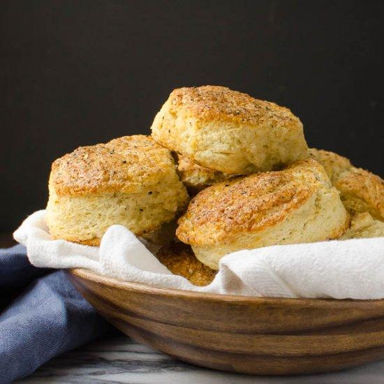

In [175]:
print(dataset[sample_idx[0]]["cat"])
print(dataset[sample_idx[0]]["caption"])
dataset[sample_idx[0]]["image"].resize((384,384))

Chow_mein
a plate of chow mein made with fried noodles, sausage strips, onions, carrot strips, and spring onions


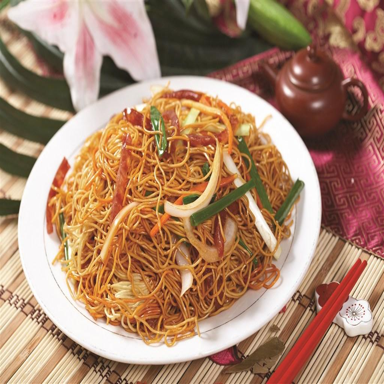

In [176]:
print(dataset[sample_idx[1]]["cat"])
print(dataset[sample_idx[1]]["caption"])
dataset[sample_idx[1]]["image"].resize((384,384))

Huevos_rancheros
Huevos rancheros are made from a large tortilla topped with avocado, tomato, bell pepper, bacon, and fried egg in a pan.


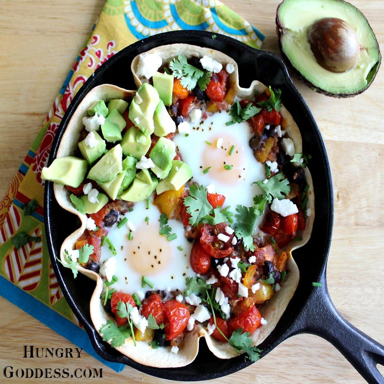

In [177]:
print(dataset[sample_idx[2]]["cat"])
print(dataset[sample_idx[2]]["caption"])
dataset[sample_idx[2]]["image"].resize((384,384))

#### Sample prediction from original MiniGPT-4

In [178]:
get_sample_predictions("MiniGPT4_original_results_30.npy",sample_idx)

['the image shows a bowl filled with homemade biscuits',
 'the dish in the image is a plate of fried noodles with vegetables and chili sauce',
 'this is a dish with eggs black beans and avocado in a cast iron skillet']

In [179]:
get_sample_predictions("MiniGPT4_original_results_60.npy",sample_idx)

['the image shows a bowl filled with homemade biscuits',
 'the dish in the image is a plate of fried noodles with vegetables and chili sauce',
 'this is a dish with eggs black beans and avocado in a cast iron skillet']

#### Sample prediction from finetuned MiniGPT-4 (fine-tuned on entire fine-tuning set)

In [180]:
get_sample_predictions("MiniGPT4_finetuned_all_results_30.npy",sample_idx)

['a bowl of golden brown biscuits with a sprinkle of cinnamon powder on top',
 'a plate of chow mein with shredded carrots green onions and red peppers',
 'a black pan of huevos rancheros with a fried egg avocado tomato and red pepper']

In [181]:
get_sample_predictions("MiniGPT4_finetuned_all_results_60.npy",sample_idx)

['a bowl of golden brown biscuits with a sprinkle of cinnamon powder on top',
 'a plate of chow mein with shredded carrots green onions and red peppers',
 'a black pan of huevos rancheros with a fried egg avocado tomato and red pepper']

### Get sample predictions from chalenging categories

#### Ground Truth

In [194]:
# Sample idx from the set of challenging labels, i.e. idx of idx_list_challenging
sample_idx_challenging = [9,60,129]

Aloo_gobi
A white bowl of Aloo gobi boiled with long beans that had been cut into pieces and a veriety of spices


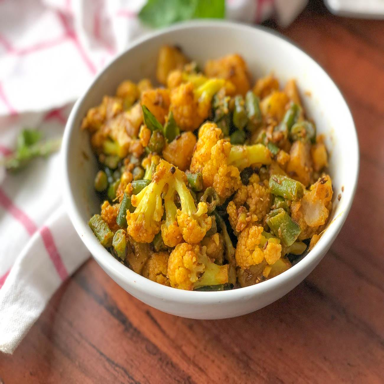

In [195]:
print(dataset[idx_list_challenging[sample_idx_challenging[0]]]["cat"])
print(dataset[idx_list_challenging[sample_idx_challenging[0]]]["caption"])
dataset[idx_list_challenging[sample_idx_challenging[0]]]["image"].resize((384,384))

Sambar
a full bowl of thick sambar cooked with onions, French beans, chopped drumsticks, and tomatoes in a thick and creamy soup, seasoned with curry leaves and decorated with mustard seeds and coriander, and served with rice on the side


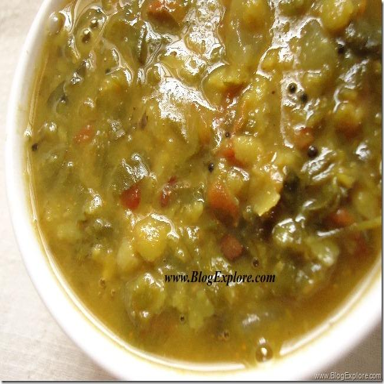

In [196]:
print(dataset[idx_list_challenging[sample_idx_challenging[1]]]["cat"])
print(dataset[idx_list_challenging[sample_idx_challenging[1]]]["caption"])
dataset[idx_list_challenging[sample_idx_challenging[1]]]["image"].resize((384,384))

Wonton_noodles
Two big pork wontons and yellow rice noodles in chicken broth with chopped green onion on the top.


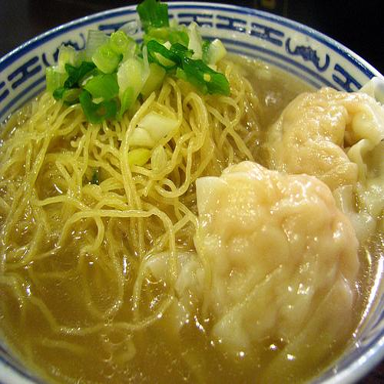

In [197]:
print(dataset[idx_list_challenging[sample_idx_challenging[2]]]["cat"])
print(dataset[idx_list_challenging[sample_idx_challenging[2]]]["caption"])
dataset[idx_list_challenging[sample_idx_challenging[2]]]["image"].resize((384,384))

#### Sample challenging prediction from finetuned MiniGPT-4 (fine-tuned on fine-tuning set excluding challenging labels)

In [198]:
get_sample_predictions("MiniGPT4_finetuned_challenging_results_30.npy",sample_idx_challenging)

['a bowl of kadhi with some green peas and some yellow cauliflower',
 'a bowl of yellow peas and spinach stew with some green peas and spinach',
 'a bowl of clear soup with a few dumplings and some chopped spring onions on the surface']

In [199]:
get_sample_predictions("MiniGPT4_finetuned_challenging_results_60.npy",sample_idx_challenging)

['a bowl of kadhi with some green peas and some yellow cauliflower',
 'a bowl of yellow peas and spinach stew with some green peas and spinach',
 'a bowl of clear soup with a few dumplings and some chopped spring onions on the surface']

#### Sample challenging prediction from finetuned MiniGPT-4 (fine-tuned on entire fine-tuning set)

In [200]:
get_sample_predictions("MiniGPT4_finetuned_all_results_30.npy",
                       list(map(lambda x: idx_list_challenging[x],sample_idx_challenging)))

['a bowl of cauliflower aloo gobi with some green peas and some cauliflower florets',
 'a bowl of yellow peas soup with green peas and red tomatoes',
 'a bowl of wonton noodles with wontons shredded pork chopped spring onions and chopped coriander']

In [201]:
get_sample_predictions("MiniGPT4_finetuned_all_results_60.npy",
                       list(map(lambda x: idx_list_challenging[x],sample_idx_challenging)))

['a bowl of cauliflower aloo gobi with some green peas and some cauliflower florets',
 'a bowl of yellow peas soup with green peas and red tomatoes',
 'a bowl of wonton noodles with wontons shredded pork chopped spring onions and chopped coriander']

#### Sample challenging prediction from original MiniGPT-4

In [202]:
get_sample_predictions("MiniGPT4_original_results_30.npy",
                       list(map(lambda x: idx_list_challenging[x],sample_idx_challenging)))

['the dish in the image is a vegetable stir fry made with broccoli green beans and other vegetables',
 'the dish in the image is a green pea and spinach soup',
 'this is a bowl of chicken noodle soup with dumplings and green onions on top']

In [203]:
get_sample_predictions("MiniGPT4_original_results_60.npy",
                       list(map(lambda x: idx_list_challenging[x],sample_idx_challenging)))

['the dish in the image is a vegetable stir fry made with broccoli green beans and other vegetables',
 'the dish in the image is a green pea and spinach soup',
 'this is a bowl of chicken noodle soup with dumplings and green onions on top']

#### Sample challenging prediction from GPT-4V

In [204]:
get_sample_predictions("GPT4V_selected_results_test_30tokens_cleaned.npy",sample_idx_challenging)

['the name of the dish in the image cannot be determined with certainty but it appears to be a vegetable curry or stirfry containing cauliflower green',
 'the dish in the image is called dal a type of indian lentil soup with visible ingredients such as lentils tomatoes and possibly herbs',
 'this dish appears to be wonton noodle soup with visible ingredients including noodles wontons and chopped green onions']

In [205]:
get_sample_predictions("GPT4V_selected_results_test_60tokens_cleaned.npy",sample_idx_challenging)

['the dish in the image is aloo gobi and the visible ingredients include cauliflower potatoes and green beans',
 'the dish in the image is dal and the visible ingredients include lentils tomatoes and various spices',
 'the dish in the image appears to be wonton noodle soup featuring ingredients such as noodles wontons and chopped green onions']